# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style


In [2]:
from pythoneeg import constants, core, visualization

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.WARNING, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [5]:
base_folder = Path("/mnt/isilon/marsh_single_unit/PythonEEG")
load_folder = base_folder / "notebooks" / "tests" / "test-wars-sox5-6"
animal_ids = [p.name for p in load_folder.glob("*") if p.is_dir()][:3]

In [6]:
def load_war(animal_id):
    logger.info(f"Loading {animal_id}")
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(load_folder / f"{animal_id}").resolve())
    if war.genotype == "Unknown":
        logger.info(f"Skipping {animal_id} because genotype is Unknown")
        return None

    war.filter_all(bad_channels=['LHip', 'RHip'])
    war.reorder_and_pad_channels(
        ["LMot", "RMot", "LBar", "RBar", "LAud", "RAud", "LVis", "RVis", "LHip", "RHip"], use_abbrevs=True
    )
    df = war.get_result(features=['psdband'])
    del war
    return df

In [7]:
# load_war(animal_ids[0])

In [8]:
df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha.pkl")
df

,animal,genotype,total_minutes,alphadelta,delta,alpha
0,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,MMut,0.0,0.219554,8.126847,6.562267
1,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,MMut,60.0,0.215210,8.300675,6.702177
2,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,MMut,120.0,0.255636,7.898984,6.505977
3,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,MMut,180.0,0.237797,8.034322,6.555118
4,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,MMut,240.0,0.207764,8.299209,6.672708
...,...,...,...,...,...,...
1458,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,MMut,1140.0,0.216192,7.352728,5.733307
1459,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,MMut,1200.0,0.215809,7.414296,5.745251
1460,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,MMut,1260.0,0.223633,7.518850,5.890640
1461,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,MMut,1320.0,0.238006,7.267134,5.708402


In [9]:
df = df.reset_index(drop=False)
df["sex"] = df["genotype"].str[0]
df["sex"] = df["sex"].map({"F": "Female", "M": "Male"})
df["genotype"] = df["genotype"].str[1:]
df['total_minutes'] = (df['total_minutes'] - 6 * 60) % 1440
for feature in ['alphadelta', 'delta', 'alpha']:
    df[f"{feature}_nobase"] = (
        df.groupby(["animal", "genotype", "sex"])
        .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
        .reset_index(level=[0, 1, 2], drop=True)
    )
df

/tmp/ipykernel_2439182/830024352.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_2439182/830024352.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_2439182/830024352.py:9: FutureWarning: DataFrameGroupBy.apply o

,index,animal,genotype,total_minutes,alphadelta,delta,alpha,sex,alphadelta_nobase,delta_nobase,alpha_nobase
0,0,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,Mut,1080.0,0.219554,8.126847,6.562267,Male,0.009255,-0.019683,0.029134
1,1,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,Mut,1140.0,0.215210,8.300675,6.702177,Male,0.004911,0.154145,0.169045
2,2,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,Mut,1200.0,0.255636,7.898984,6.505977,Male,0.045337,-0.247546,-0.027156
3,3,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,Mut,1260.0,0.237797,8.034322,6.555118,Male,0.027498,-0.112208,0.021986
4,4,#2 Cage 2A_ab0b88674567288a96c19f2d3923ada9d14...,Mut,1320.0,0.207764,8.299209,6.672708,Male,-0.002535,0.152678,0.139576
...,...,...,...,...,...,...,...,...,...,...,...
1458,1458,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,Mut,780.0,0.216192,7.352728,5.733307,Male,-0.060679,0.361280,0.110236
1459,1459,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,Mut,840.0,0.215809,7.414296,5.745251,Male,-0.061062,0.422848,0.122180
1460,1460,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,Mut,900.0,0.223633,7.518850,5.890640,Male,-0.053238,0.527402,0.267570
1461,1461,mouse M5 cage4A_7d99da69412eb5b0bbbd5bf55ae338...,Mut,960.0,0.238006,7.267134,5.708402,Male,-0.038866,0.275687,0.085331


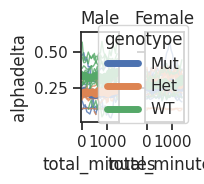

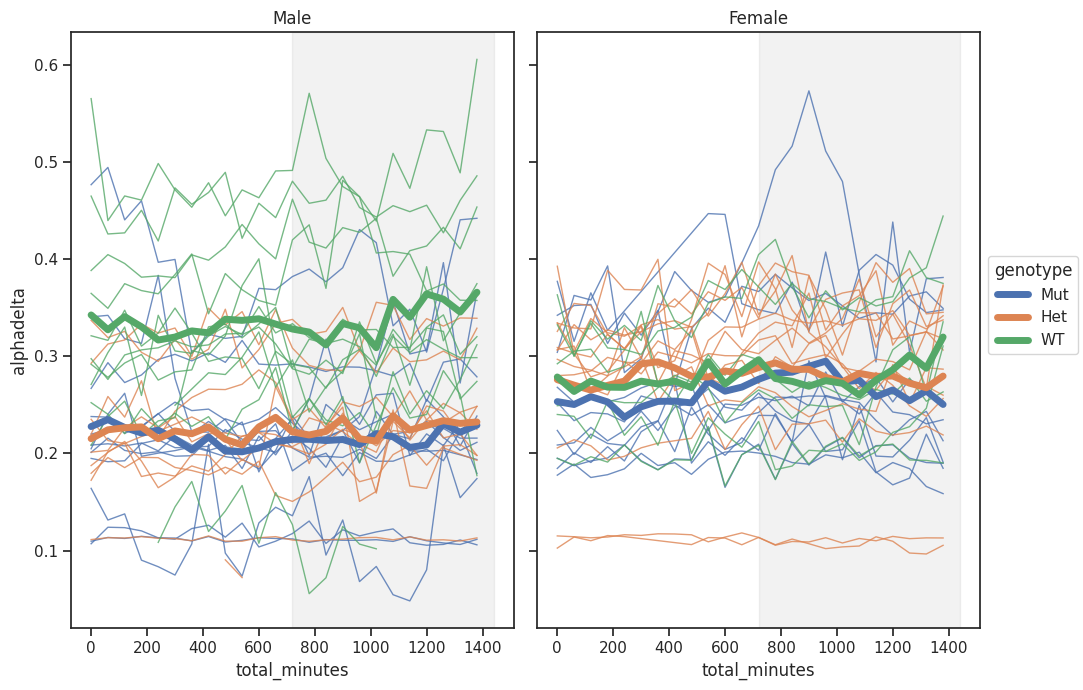

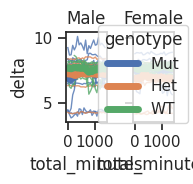

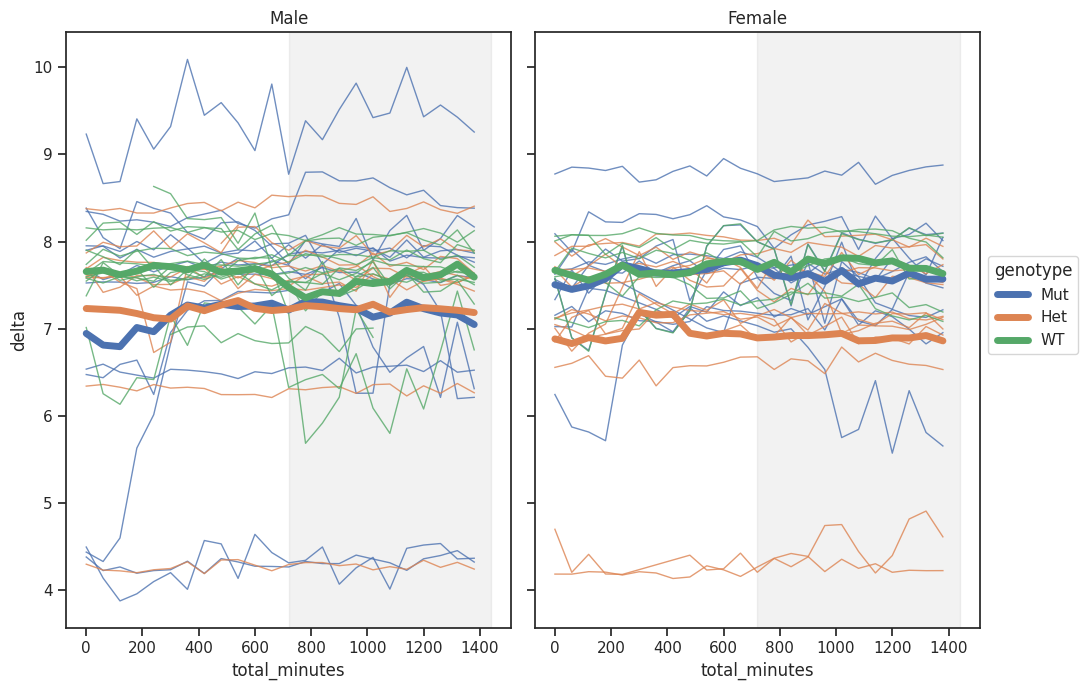

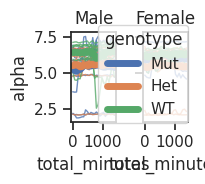

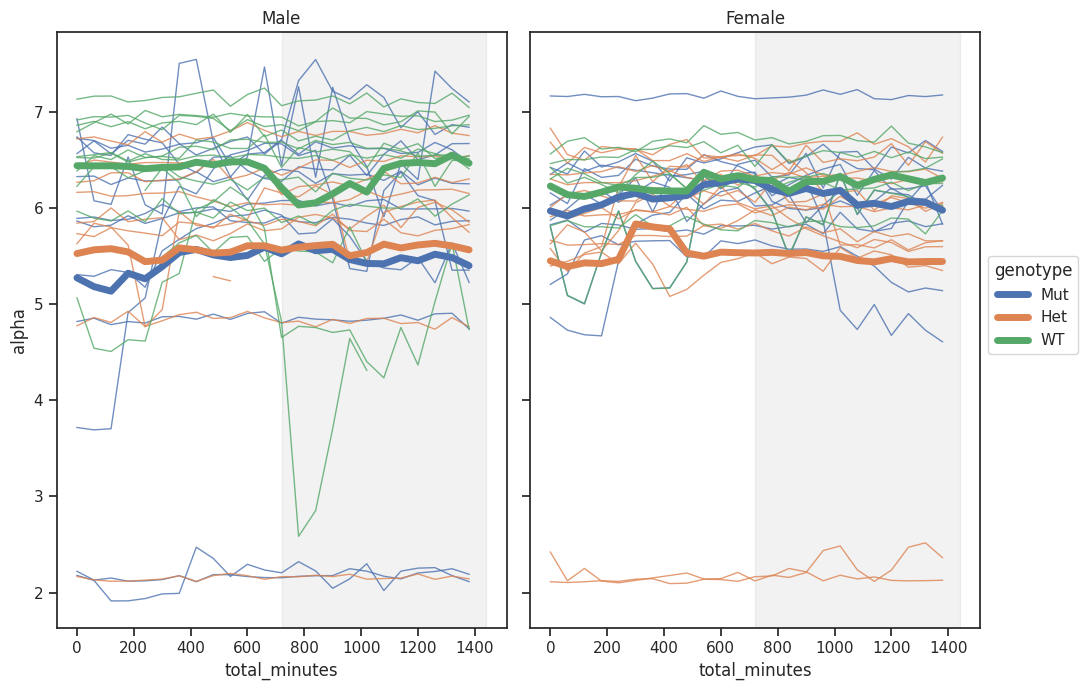

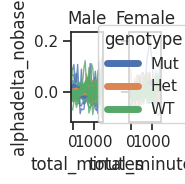

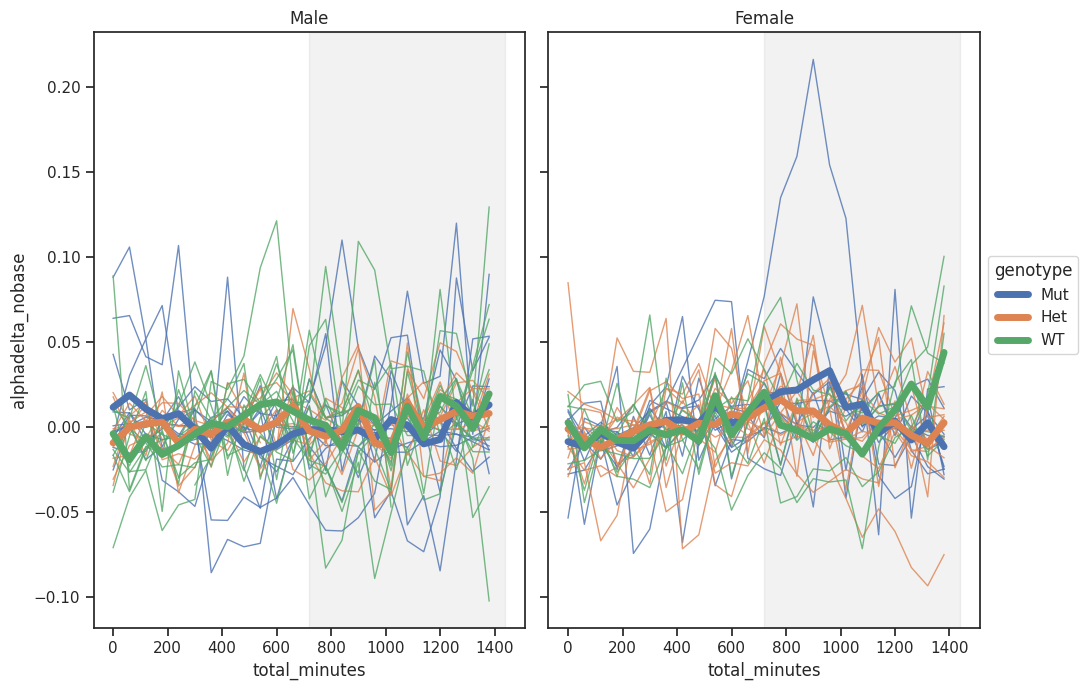

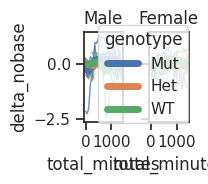

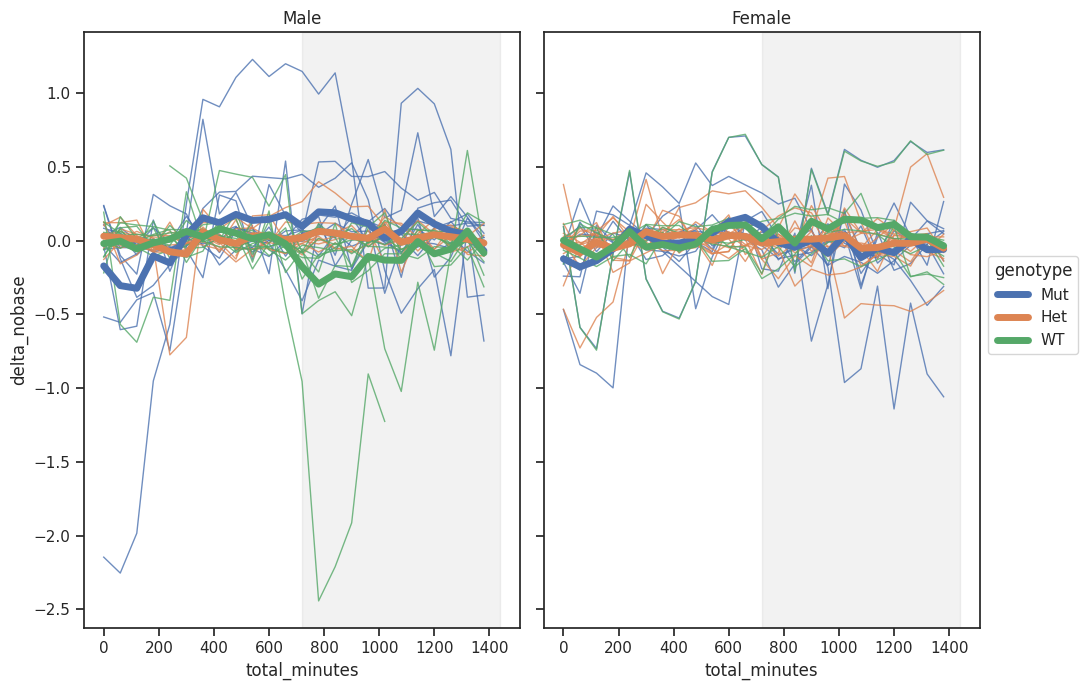

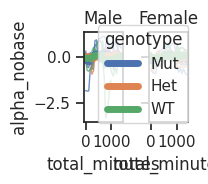

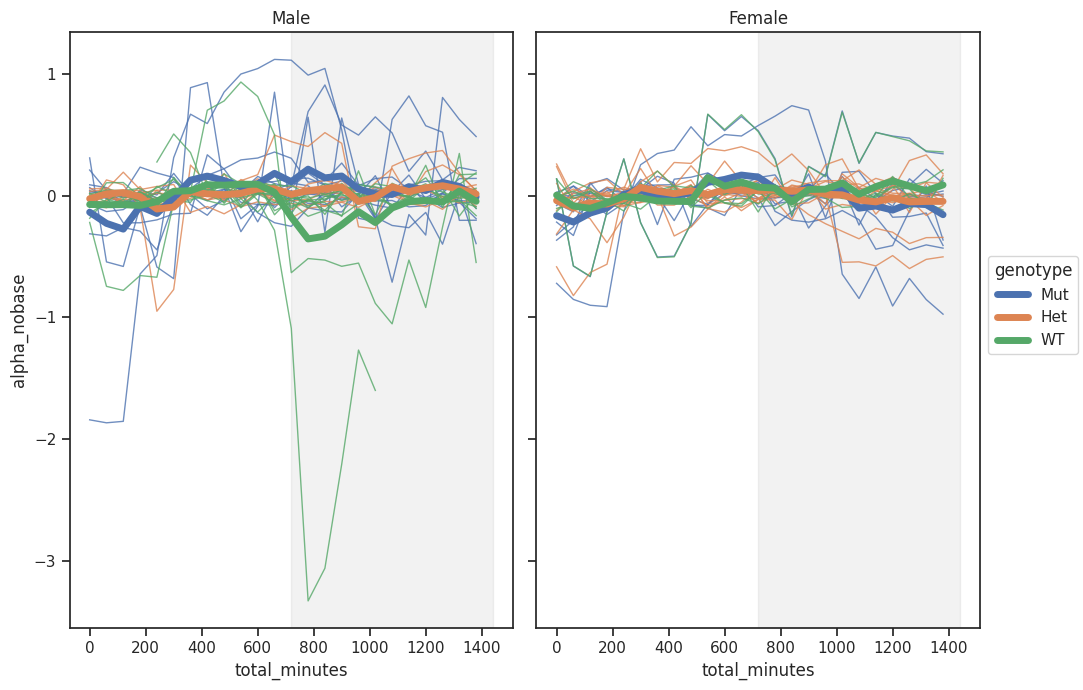

In [11]:
import matplotlib as mpl
for feature in ['alphadelta', 'delta', 'alpha', 'alphadelta_nobase', 'delta_nobase', 'alpha_nobase']:
    p = (  # fmt: off
        so.Plot(df, x="total_minutes", y=feature, color='genotype')  # fmt: off
        .facet(col='sex')
        .add(so.Lines(linewidth=1, alpha=0.8), group='animal')
        .add(so.Line(linewidth=5), so.Agg())
        # .add(so.Band(), so.Est())
        .layout(size=(2, 2))
        .theme(axes_style("ticks"))
    )
    fig = mpl.figure.Figure(figsize=(10, 7))
    p.show()
    p.on(fig).plot()
    for ax in fig.axes:
        # ax.axvspan(xmin=0, xmax=6 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=12 * 60, xmax=24 * 60, alpha=0.1, color='grey')
    fig.tight_layout()
    display(fig)
    plt.close()
